# Fitting
Demonstration of fitting mion peak for energy calibration, its accuracy and how to use it.

In [116]:
import numpy as np
import scipy.optimize as so
import matplotlib.pyplot as pp
import pandas as pd
import scipy.integrate as si
import time as t

In [2]:
CSV_file = './data/events.csv'      # CSV file with events to load

In [3]:
events = pd.read_csv(CSV_file, sep='\t', usecols=[1,2,3])
events.head()

,time,detector,energy
0,8.514833e+10,58.0,0.000001
1,8.514833e+10,13.0,0.000001
2,8.514834e+10,3.0,0.000001
3,8.514835e+10,58.0,0.000001
4,8.514836e+10,30.0,0.000001


### Filtering mions
Using sorted array.

In [4]:
mion_crit = 5
simultaneity = 1e-5

In [5]:
energies = []
for i in range(len(events['time'])-mion_crit):
        t1 = events['time'][i]
        t2 = events['time'][i+mion_crit-1]
        if t2 - t1 < simultaneity:
            if events['time'][i+mion_crit]-t1 < simultaneity:     # longer row of simultaneous events than mion_crit
                energies.append(events['energy'][i])
            else:
                for j in range(mion_crit):                          # append with the rest and add it to i
                    energies.append(events['energy'][i+j])
                i += mion_crit
energies = np.array(energies)*1e9

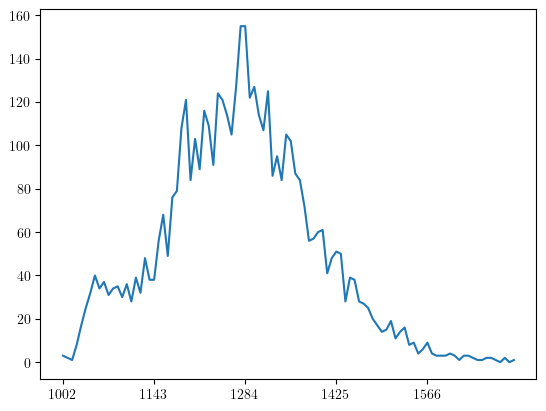

In [6]:
n_bins = 100
hist, bins = np.histogram(energies, bins=n_bins)
pp.plot(hist)
proc20 = int(n_bins/5)
pp.xticks([proc20*i for i in range(5)], [int(bins[proc20*i]) for i in range(5)])
xedges = [np.min(bins), np.max(bins)]

### Fitting Landau distribution
Using `scipy.optimize.minimize`.

In [47]:
progress = []
landau_inf = 100
def landau(x, mu, c):
        x_int = np.linspace(1e-3, landau_inf, 5000)
        y_int = [np.e**(-t) * np.cos(t*(x-mu)/c + 2*t/np.pi*np.log(t/c)) for t in x_int]
        return 1/(np.pi*c) * si.simpson(y_int, x=x_int)

def landau_mse(param):
    mu = param[0]
    c = param[1]
    scale = param[2]
    result = []
    x = np.linspace(xedges[0], xedges[1], n_bins)
    for given_x in x:
        result.append(landau(given_x, mu, c)*scale)
    fit = np.array(result)
    mse = (np.square(fit-hist)).mean()
    progress.append(mse)
    return mse

In [51]:
class Stopper:
    def __init__(self, max_sec=30):
        self.max_sec = max_sec
        self.start = t.time()
    def stopIteration(self, xk):
        if (t.time() - self.start) > self.max_sec:
            raise StopIteration

In [52]:
def plot_landau(mu, c, scale):
    x = np.linspace(1000, 1600, 100)
    result = []
    for given_x in x:
        result.append(landau(given_x, mu, c)*scale)
    result = np.array(result)
    return x, result

In [53]:
progress = []
stopper = Stopper(max_sec=60)
res_landau = so.minimize(landau_mse, [1000, 80, 40000], method='Nelder-Mead', callback=stopper.stopIteration)
print(f'Final MSE: {landau_mse(res_landau.x)}')

Final MSE: 343.9698959700672


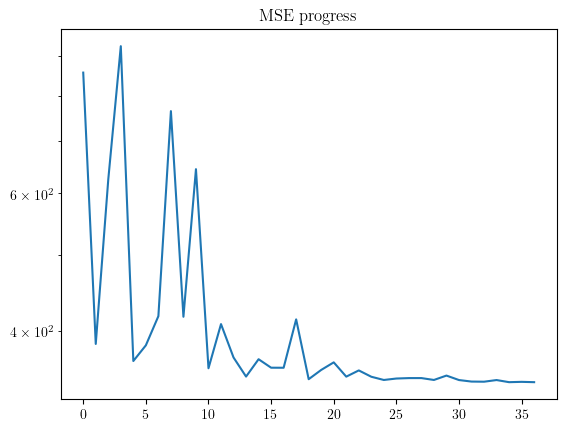

In [54]:
pp.plot(progress)
pp.yscale('log')
pp.title('MSE progress')
pp.show()

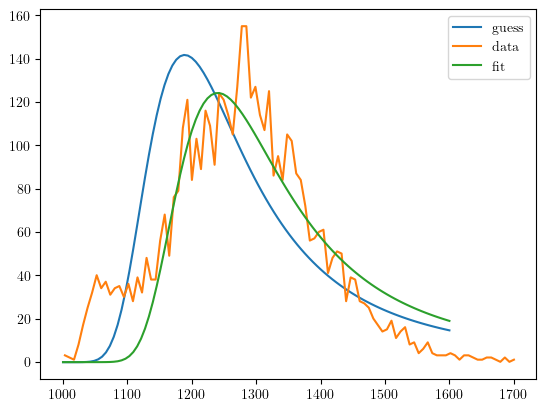

In [55]:
# plot guess and fit
x, result = plot_landau(1000, 80, 40000)
fit = res_landau.x
x2, fit_result = plot_landau(fit[0], fit[1], fit[2])
pp.plot(x, result, label='guess')
pp.plot(bins[:-1], hist, label='data')
pp.plot(x2, fit_result, label='fit')
pp.legend()
pp.show()

### Fitting Langau distribution

In [88]:
progress = []
landau_inf = 100
def landau(x, mu, c):
    x_int = np.linspace(1e-3, landau_inf, 5000)
    y_int = [np.e**(-t) * np.cos(t*(x-mu)/c + 2*t/np.pi*np.log(t/c)) for t in x_int]
    return 1/(np.pi*c) * si.simpson(y_int, x=x_int)

def gauss(x, mu, sigma):
    const = 1/(np.sqrt(2*np.pi*sigma**2))
    exponential = np.exp((-((x-mu)**2)) / (2*sigma**2))
    return const*exponential

def langau_mse(param):
    mu_landau = param[0]
    c = param[1]
    scale = param[2]
    mu_gauss = param[3]
    sigma = param[4]
    result = []
    x = np.linspace(xedges[0], xedges[1], n_bins)
    for given_x in x:
        result.append(landau(given_x, mu_landau, c)*scale * gauss(given_x, mu_gauss, sigma))
    fit = np.array(result)
    mse = (np.square(fit-hist)).mean()
    progress.append(mse)
    return mse

In [89]:
def plot_langau(mu, c, scale, mu_gauss, sigma):
    x = np.linspace(1000, 1600, 100)
    result = []
    for given_x in x:
        result.append(landau(given_x, mu, c)*scale * gauss(given_x, mu_gauss, sigma))
    result = np.array(result)
    return x, result

In [91]:
progress = []
stopper = Stopper(max_sec=20)
res_langau = so.minimize(langau_mse, [1000, 80, 2e7, 1300, 150], method='Nelder-Mead', callback=stopper.stopIteration)
print(f'Final MSE: {langau_mse(res_langau.x)}')

Final MSE: 242.97101891677622


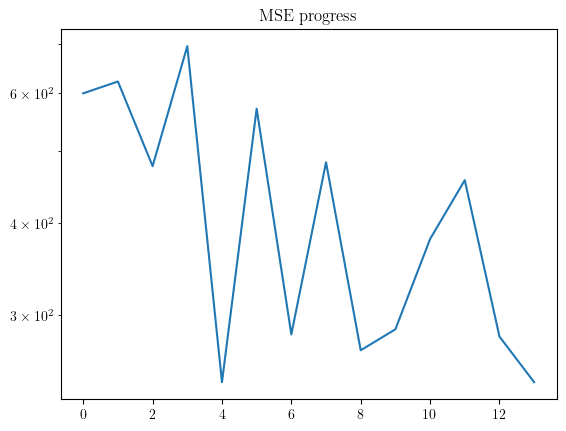

In [92]:
pp.plot(progress)
pp.yscale('log')
pp.title('MSE progress')
pp.show()

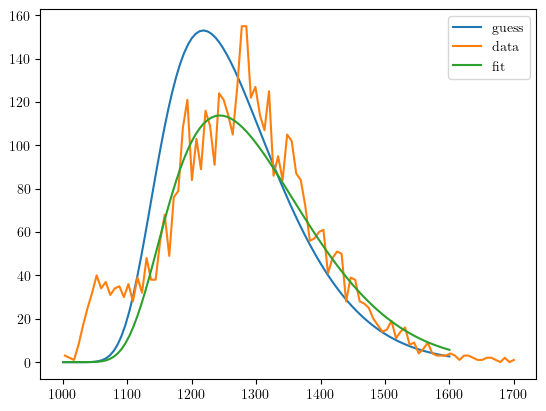

In [94]:
# plot guess and fit
x, result = plot_langau(1000, 80, 2e7, 1300, 150)
fit = res_langau.x
x2, fit_result = plot_langau(fit[0], fit[1], fit[2], fit[3], fit[4])
pp.plot(x, result, label='guess')
pp.plot(bins[:-1], hist, label='data')
pp.plot(x2, fit_result, label='fit')
pp.legend()
pp.show()

### Fitting Langau distribution using convolution

In [95]:
def langau_conv_mse(param):
    mu_landau = param[0]
    c = param[1]
    scale = param[2]
    mu_gauss = param[3]
    sigma = param[4]
    langau_result = []
    x = np.linspace(xedges[0], xedges[1], n_bins)
    for given_x in x:
        langau_result.append(landau(given_x, mu_landau, c)*scale * gauss(given_x, mu_gauss, sigma))
    fit = np.convolve(np.array(langau_result), np.array(langau_result), 'same')     # convolution
    mse = (np.square(fit-hist)).mean()
    progress.append(mse)
    return mse

In [96]:
def plot_langau_conv(mu, c, scale, mu_gauss, sigma):
    x = np.linspace(1000, 1600, 100)
    result = []
    for given_x in x:
        result.append(landau(given_x, mu, c)*scale * gauss(given_x, mu_gauss, sigma))
    result = np.convolve(np.array(result), np.array(result), 'same')
    return x, result

In [105]:
progress = []
stopper = Stopper(max_sec=60)
res_langau_conv = so.minimize(langau_conv_mse, [1050, 80, 3e5, 1300, 150], method='Nelder-Mead', callback=stopper.stopIteration)
print(f'Final MSE: {langau_conv_mse(res_langau_conv.x)}')

Final MSE: 179.42825811174458


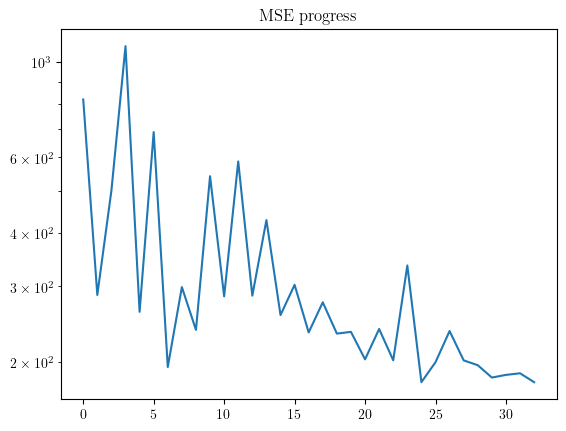

In [106]:
pp.plot(progress)
pp.yscale('log')
pp.title('MSE progress')
pp.show()

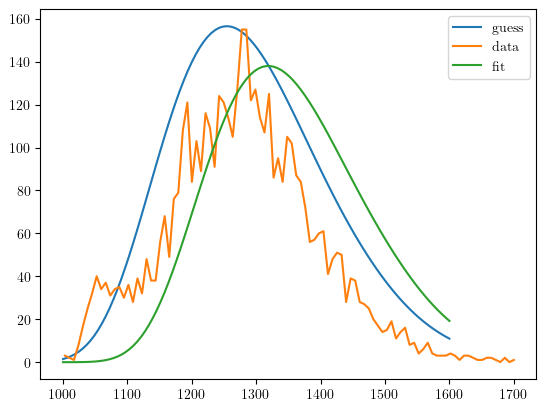

In [107]:
# plot guess and fit
x, result = plot_langau_conv(1050, 80, 3e5, 1300, 150)
fit = res_langau_conv.x
x2, fit_result = plot_langau_conv(fit[0], fit[1], fit[2], fit[3], fit[4])
pp.plot(x, result, label='guess')
pp.plot(bins[:-1], hist, label='data')
pp.plot(x2, fit_result, label='fit')
pp.legend()
pp.show()

# Results

In [112]:
# compare or fits
# CALCULATION

time_for_each = 120     # in seconds

stopper = Stopper(max_sec=time_for_each)
res_landau = so.minimize(landau_mse, [1000, 80, 40000], method='Nelder-Mead', callback=stopper.stopIteration)
print('Landau done.')
stopper = Stopper(max_sec=time_for_each)
res_langau = so.minimize(langau_mse, [1000, 80, 2e7, 1300, 150], method='Nelder-Mead', callback=stopper.stopIteration)
print('Langauss done.')
stopper = Stopper(max_sec=time_for_each)
res_langau_conv = so.minimize(langau_conv_mse, [1050, 80, 3e5, 1300, 150], method='Nelder-Mead', callback=stopper.stopIteration)
print('Langauss convolute done.')

Landau done.
Langauss done.
Langauss convolute done.


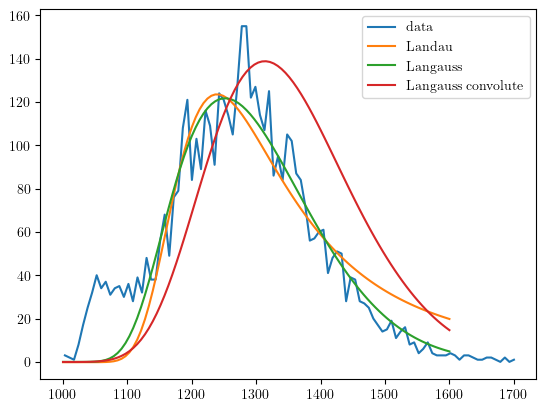

Landau MSE: 342.0321860801546
Langauss MSE: 203.1817334322367
Langauss convolute MSE: 161.55032174113924


In [113]:
fit_L = res_landau.x
x, fit_result_L = plot_landau(fit_L[0], fit_L[1], fit_L[2])
fit_LG = res_langau.x
x, fit_result_LG = plot_langau(fit_LG[0], fit_LG[1], fit_LG[2], fit_LG[3], fit_LG[4])
fit_LGC = res_langau_conv.x
x, fit_result_LGC = plot_langau_conv(fit_LGC[0], fit_LGC[1], fit_LGC[2], fit_LGC[3], fit_LGC[4])
pp.plot(bins[:-1], hist, label='data')
pp.plot(x, fit_result_L, label='Landau')
pp.plot(x, fit_result_LG, label='Langauss')
pp.plot(x, fit_result_LGC, label='Langauss convolute')
pp.legend()
pp.show()
print(f"Landau MSE: {landau_mse(fit_L)}")
print(f"Langauss MSE: {langau_mse(fit_LG)}")
print(f"Langauss convolute MSE: {langau_conv_mse(fit_LGC)}")

### Evolution of MSE in time

In [ ]:
def landau_time(time):
    stopper = Stopper(max_sec=time)
    res_landau = so.minimize(landau_mse, [1000, 80, 40000], method='Nelder-Mead', callback=stopper.stopIteration)
    return landau_mse(res_landau.x)

def langau_time(time):
    stopper = Stopper(max_sec=time)
    res_langau = so.minimize(langau_mse, [1000, 80, 2e7, 1300, 150], method='Nelder-Mead', callback=stopper.stopIteration)
    return langau_mse(res_langau.x)

def langau_conv_time(time):
    stopper = Stopper(max_sec=time)
    res_langau_conv = so.minimize(langau_conv_mse, [1050, 80, 3e5, 1300, 150], method='Nelder-Mead', callback=stopper.stopIteration)
    return langau_conv_mse(res_langau_conv.x)

In [ ]:
times = [10, 30, 60, 120, 360, 720, 1440, 2880, 5760, 11520]

L_mse = []
LG_mse = []
LGC_mse = []

for ti in times:
    L_mse.append(landau_time(ti))
    LG_mse.append(langau_time(ti))
    LGC_mse.append(langau_conv_time(ti))

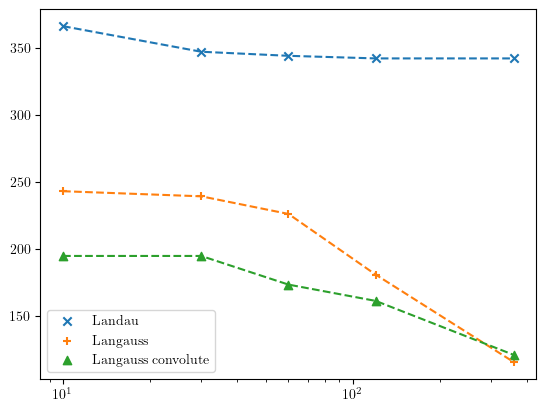

In [123]:
pp.plot(times, L_mse, linestyle='dashed')
pp.plot(times, LG_mse, linestyle='dashed')
pp.plot(times, LGC_mse, linestyle='dashed')
pp.scatter(times, L_mse, marker='x', label='Landau')
pp.scatter(times, LG_mse, marker='+', label='Langauss')
pp.scatter(times, LGC_mse, marker='^', label='Langauss convolute')
pp.xscale('log')
pp.legend()
pp.show()